In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from biopandas.pdb import PandasPdb
plt.rcParams['svg.fonttype'] = 'none'

def get_expected_Q_RNA(res):
    # new Q(resolution)
    # Q_mean = -0.0016d3 + 0.0434d2 - 0.3956x + 1.3366    (eqn.1)
    # Q_peak = Q_mean + 0.024                                           (eqn.2)
    # Q_low_95% = Q_mean - 0.126                                     (eqn.3)
    # Q_high_95% = Q_mean + 0.109                                   (eqn.4)
    ole_Q = (-0.138*res)+0.997
    new_Qmean = (-0.0016 * (res**3)) + (0.0434 *(res**2)) - (0.3956 * res) + 1.3366
    new_Qpeak = new_Qmean + 0.024 
    new_Qlow = new_Qmean - 0.126  
    new_Qhigh = new_Qmean + 0.109
    print(new_Qmean,ole_Q)
    return ole_Q

def get_B_from_Q(Q):
    return 150*(1-Q)

def plot_Q(Q_file,res):
    Q_df  = pd.read_csv(Q_file)
    #for i,Q in Q_df.groupby('Chain'):
    sns.lineplot(Q_df,x='Number',y='Qavg',color='black',errorbar=('pi',100))
    plt.xlim(Q_df.Number.min(),Q_df.Number.max())
    plt.ylim(0,1)
    plt.hlines(get_expected_Q_RNA(res),Q_df.Number.min(),Q_df.Number.max(),'blue',':')
    plt.ylabel('Q-score')
    plt.xlabel('Residue')
    plt.grid(axis='y')
    
def get_5_digit_numbers(num):
    num+=1
    if num < 100000:
        return str(num)
    elif num < (26*2)*10000:
        first = chr(65+((num-100000)//10000))
        second = str((num-100000)%10000)
        return first+second
    # TODO will not go beyond this, not needed for these molecules

def clean_pdb(pdb,cutpoints):
    ters = []
    for cut in cutpoints:
        for chain in pdb.df['ATOM'].chain_id.unique():
            new_row = {'record_name': 'TER',
                        'atom_number': 9999,  
                        'blank_1':'',
                        'atom_name': 'Z',
                        'alt_loc': '',
                        'residue_name': pdb.df['ATOM'][(pdb.df['ATOM'].chain_id==chain) &(pdb.df['ATOM'].residue_number==cut)].residue_name.unique()[0],
                       'blank_2':'',
                        'chain_id': chain,
                        'residue_number': cut,
                        'insertion': '',
                        'blank_3':'',
                        'x_coord': 10.0,
                        'y_coord': 20.0,
                        'z_coord': 30.0,
                        'occupancy': 1.00,
                        'b_factor': 30.00,
                        'element_symbol': 'Z',
                        'blank_4':'', 'segment_id':'', 
                        'charge': 0,'line_idx':0
                    }
            ters.append(new_row)
    pdb.df['ATOM'] = pd.concat([pdb.df['ATOM'],pd.DataFrame(ters)], ignore_index=True)
    pdb.df['ATOM'] = pdb.df['ATOM'].sort_values(['chain_id','residue_number'])
    pdb.df['ATOM'] = pdb.df['ATOM'][pdb.df['ATOM'].element_symbol!='H']
    pdb.df['ATOM'] = pdb.df['ATOM'].reset_index(drop=True)
    pdb.df['ATOM']['line_idx'] = pdb.df['ATOM'].index
    pdb.df['ATOM']['atom_number'] = pdb.df['ATOM'].line_idx.apply(get_5_digit_numbers)  
    
    pdb.df['OTHERS'] = pdb.df['OTHERS'][pdb.df['OTHERS'].record_name=='XXX']#'TER']
    print(pdb.df['OTHERS'] )#'TER    9916   XXX   A   A 371'
    return pdb

    
def fix_pandaspdb_factor_error(pdb_file):
    with open(pdb_file, 'r') as file:
        data = file.readlines()
    new_data = []
    for line in data:
        if 'ATOM' == line[:4] and line[64]=='.':
            new_num = str(round(float(line[60:68]),2))
            if len(new_num)==5:
                new_num+='0 '
            else:
                new_num+=' '
            line = line[:60] + new_num + line[68:]
        elif 'TER' == line[:3]:
            line = line[:13]+'   '+line[16:28] +'\n'
        new_data.append(line)
    with open(pdb_file, 'w') as file:
        file.writelines( new_data ) 

# TER    5618  Z     G A 290      10.000  20.000  30.000  1.00 99.75           Z 0.0

def Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[]):
    Q  = pd.read_csv(Q_file)
    Q['Bfactor'] = Q.Qavg.apply(get_B_from_Q)
    Bfactor = Q.set_index('Number').Bfactor.to_dict()
    pdb = PandasPdb().read_pdb(pdb_file)
    pdb = clean_pdb(pdb,cutpoints) 
    print(f'Num atoms: {len(pdb.df["ATOM"])}')
    print(f'Num resds: {len(pdb.df["ATOM"].groupby(["residue_number","chain_id"]).count())}')
    pdb.df['ATOM']['b_factor'] = pdb.df['ATOM'].residue_number.map(Bfactor)
    pdb.to_pdb(pdb_file)
    fix_pandaspdb_factor_error(pdb_file)
    
# TODO right now just did per residue Bfactor(Q), can do per atom    
# TODO can add regions at bottom if have time



0.5153316 0.5968
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 4335
Num resds: 202


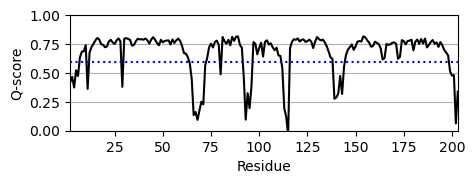

In [4]:
Q_file = 'data/raiA_Qscore.csv'
res = 2.9
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)
plt.savefig('raiA_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('raiA_Q.png',dpi=400, bbox_inches="tight", transparent=True)

pdb_file = 'data/raiA_FINAL.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[203])

0.5153316 0.5968
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 13212
Num resds: 616


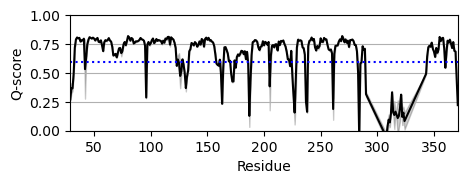

In [8]:
Q_file = 'data/ole_Qscore.csv'
res = 2.9
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)
plt.savefig('ole_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('ole_Q.png',dpi=400, bbox_inches="tight", transparent=True)

pdb_file = 'data/OLE_FINAL.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[290,324,371])

0.47964839999999986 0.5691999999999999
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 102256
Num resds: 4784


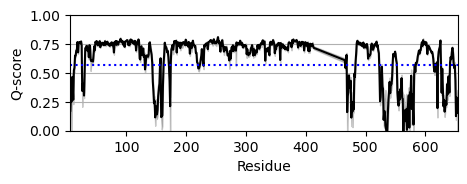

In [3]:
Q_file = 'data/rool_Qscore.csv'
res = 3.1
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)

plt.savefig('rool_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('rool_Q.png',dpi=400, bbox_inches="tight", transparent=True)

pdb_file = 'data/ROOL_FINAL.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[413,654])

0.47964839999999986 0.5691999999999999
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 102232
Num resds: 4784


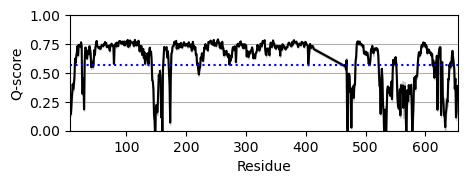

In [2]:
Q_file = 'data/rool_refined_Qscore.csv'
res = 3.1
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)

plt.savefig('rool_refined_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('rool_refined_Q.png',dpi=400, bbox_inches="tight", transparent=True)

pdb_file = 'data/ROOL_refined_corrected.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[413,654])

0.47964839999999986 0.5691999999999999
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 102240
Num resds: 4784


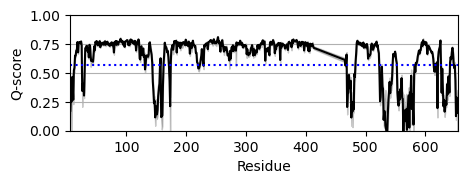

In [6]:
Q_file = 'data/rool_Qscore.csv'
res = 3.1
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)

plt.savefig('rool_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('rool_Q.png',dpi=400, bbox_inches="tight", transparent=True)

pdb_file = 'data/ROOL_final_corrected2.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[413,654])

0.49719999999999986 0.583
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 235802
Num resds: 11032


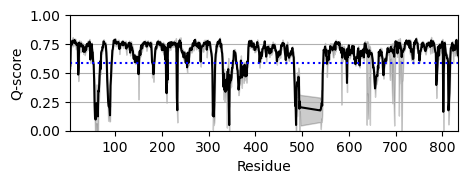

In [13]:
Q_file = 'data/golld_Qscore.csv'
res = 3.0
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)
plt.savefig('golld_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('golld_Q.png',dpi=400, bbox_inches="tight", transparent=True)
#
pdb_file = 'data/GOLLD_FINAL.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[496,833])

0.49719999999999986 0.583
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 235872
Num resds: 11032


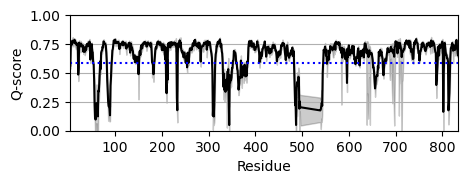

In [8]:
Q_file = 'data/golld_Qscore.csv'
res = 3.0
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)
plt.savefig('golld_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('golld_Q.png',dpi=400, bbox_inches="tight", transparent=True)
#
pdb_file = 'data/GOLLD_FINAL_Corrected.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[496,833])

0.49719999999999986 0.583
Empty DataFrame
Columns: [record_name, entry, line_idx]
Index: []
Num atoms: 235872
Num resds: 11032


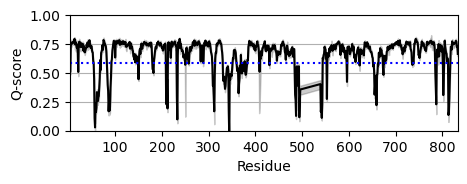

In [4]:
Q_file = 'data/golld_refined_Qscore.csv'
res = 3.0
plt.figure(figsize=(5,1.5))
plot_Q(Q_file,res)
plt.savefig('golld_refined_Q.svg',dpi=400, bbox_inches="tight", transparent=True)
plt.savefig('golld_refined_Q.png',dpi=400, bbox_inches="tight", transparent=True)
#
pdb_file = 'data/GOLLD_refined_corrected.pdb' 
Bfactor_per_res_edit_pdbfile(pdb_file,Q_file,cutpoints=[496,833])